In [0]:
# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [13]:
# This code block downloads the full Cats-v-Dogs dataset and stores it as 
# cats-and-dogs.zip. It then unzips it to /tmp
# which will create a tmp/PetImages directory containing subdirectories
# called 'Cat' and 'Dog' (that's how the original researchers structured it)
# If the URL doesn't work, 
# .   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2020-02-03 19:42:42--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 2.21.40.213, 2a02:26f0:6b:5b3::e59, 2a02:26f0:6b:5a5::e59
Connecting to download.microsoft.com (download.microsoft.com)|2.21.40.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   196MB/s    in 4.0s    

2020-02-03 19:42:46 (195 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [14]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [15]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:

  import shutil
  base_dir = '/tmp/cats-v-dogs'
  
  if os.path.exists(base_dir):
    print('removing folder + all files')
    shutil.rmtree(base_dir)

  train_dir = os.path.join(base_dir, 'training')
  test_dir = os.path.join(base_dir, 'testing')

  # Directory with our training cat/dog pictures
  train_cats_dir = os.path.join(train_dir, 'cats')
  train_dogs_dir = os.path.join(train_dir, 'dogs')

  os.makedirs(train_cats_dir)
  os.makedirs(train_dogs_dir)

  # Directory with our test cat/dog pictures
  test_cats_dir = os.path.join(test_dir, 'cats')
  test_dogs_dir = os.path.join(test_dir, 'dogs')

  os.makedirs(test_cats_dir)
  os.makedirs(test_dogs_dir)
except OSError:
    pass

removing folder + all files


In [16]:
# Write a python function called split_data which takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copie to
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE is .9
# Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
#
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  # YOUR CODE STARTS HERE
  source_list = os.listdir(SOURCE)

  for i in source_list:
    if os.path.getsize(SOURCE+'/'+i) == 0:
      source_list.remove(i)
      print(i,'is zero length, so ignoring')

  source_len = len(source_list)

  source_list = random.sample(source_list, source_len)
  training_size = int(source_len*SPLIT_SIZE)

  training_list = source_list[:training_size]
  print(len(training_list))

  test_list = source_list[training_size:]
  print(len(test_list))

  for i in training_list:
    copyfile(SOURCE+'/'+i,TRAINING+i)

  for i in test_list:
    copyfile(SOURCE+'/'+i,TESTING+i)

  # YOUR CODE ENDS HERE



CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring
11250
1250
11702.jpg is zero length, so ignoring
11250
1250


In [17]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


In [0]:
# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
# USE AT LEAST 3 CONVOLUTION LAYERS
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

In [19]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')




# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [21]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=200,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

# The expectation here is that the model will train, and that accuracy will be > 95% on both training and validation
# i.e. acc:A1 and val_acc:A2 will be visible, and both A1 and A2 will be > .9

Epoch 1/200
Epoch 1/200
100/100 - 19s - loss: 0.5059 - acc: 0.7485 - val_loss: 0.4574 - val_acc: 0.7890
Epoch 2/200
Epoch 1/200
100/100 - 18s - loss: 0.5486 - acc: 0.7160 - val_loss: 0.4489 - val_acc: 0.8110
Epoch 3/200


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

Epoch 1/200
100/100 - 17s - loss: 0.5257 - acc: 0.7360 - val_loss: 0.5128 - val_acc: 0.7500
Epoch 4/200
Epoch 1/200
100/100 - 18s - loss: 0.5289 - acc: 0.7420 - val_loss: 0.4556 - val_acc: 0.7870
Epoch 5/200
Epoch 1/200
100/100 - 18s - loss: 0.5301 - acc: 0.7330 - val_loss: 0.4618 - val_acc: 0.7790
Epoch 6/200
Epoch 1/200
100/100 - 18s - loss: 0.5388 - acc: 0.7382 - val_loss: 0.4517 - val_acc: 0.7890
Epoch 7/200
Epoch 1/200
100/100 - 18s - loss: 0.5333 - acc: 0.7400 - val_loss: 0.5567 - val_acc: 0.7070
Epoch 8/200
Epoch 1/200
100/100 - 17s - loss: 0.5335 - acc: 0.7345 - val_loss: 0.4224 - val_acc: 0.8080
Epoch 9/200
Epoch 1/200
100/100 - 18s - loss: 0.5054 - acc: 0.7540 - val_loss: 0.4589 - val_acc: 0.7930
Epoch 10/200
Epoch 1/200
100/100 - 18s - loss: 0.5234 - acc: 0.7455 - val_loss: 0.4842 - val_acc: 0.7660
Epoch 11/200
Epoch 1/200
100/100 - 18s - loss: 0.5197 - acc: 0.7515 - val_loss: 0.4453 - val_acc: 0.7960
Epoch 12/200
Epoch 1/200
100/100 - 18s - loss: 0.5118 - acc: 0.7530 - val_

Text(0.5, 1.0, 'Training and validation loss')

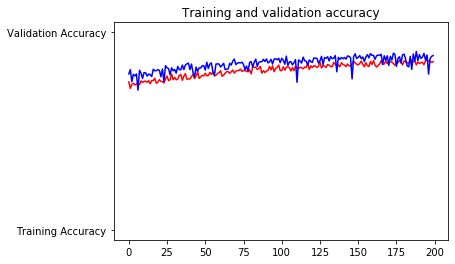

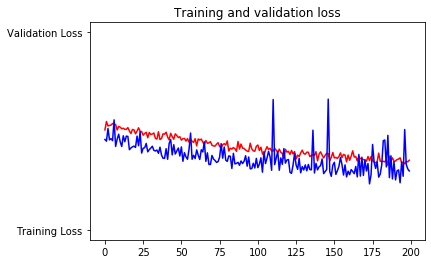

In [22]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [26]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Using TensorFlow backend.


Saving Bez tytułu.png to Bez tytułu.png
[1.]
Bez tytułu.png is a dog
